In [137]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

# Data loading

## Movie data

movie.metadata.tsv.gz [3.4 M]
Metadata for 81,741 movies, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

In [138]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [139]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [140]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Character data

character.metadata.tsv.gz [14 M]
Metadata for 450,669 characters aligned to the movies above, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:

- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

In [141]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
229104,29771748,/m/0fq0q4y,2010-11-24,Po,1969-08-28,M,1.68,/m/07bch9,Jack Black,41.0,/m/0gy79cc,/m/04sthy0,/m/01vsn38
29613,18711502,/m/04gr1q4,2008-08-08,NaN,1965-07-02,M,NaN,NaN,Krishna Bhagavaan,43.0,/m/04lrnp7,NaN,/m/02vn3cv
309997,29429988,/m/0ds0s8y,2011-12-15,Tribal Princess,1983-12-25,F,NaN,NaN,Kwai Lun-mei,27.0,/m/0gvx0t8,/m/0k7h7dm,/m/03gqgq6
107768,3213541,/m/08zr0g,1955,NaN,1919-05-01,M,NaN,/m/03bkbh,Dan O'Herlihy,35.0,/m/0k6ty4,NaN,/m/015d2r
67050,25917921,/m/0b6mjb4,2010-09-03,Nadia,NaN,F,NaN,NaN,Yasmine Elmasri,NaN,/m/0cq9bvb,/m/0gfr686,/m/0bnn925


freebase_character_actor_map_id ?
movies are referred to by wikipedia id or freebase id
lots of data missing especially for: ethnicity, charcter name (maybe some characters aren't named in movies) , 
different date formats for release date 

## IMDB top 1000 data

This dataset includes IMDB top 1,000 movies of all time with attributes such as Title, Certificate, Duration, Genre, etc.
source: https://www.kaggle.com/datasets/omarhanyy/imdb-top-1000

- Poster_Link
- Series_Title: Title of movie
- Release_year: Movie release year
- Certificate
- Runtime [min]
- Genre
- IMDB_Rating: IMDB rating over 10
- Overview: brief summary
- Meta_score: rating by critiques
- Director
- Star 1, 2, 3, 4
- No_of_Votes: Number of votes
- Gross: Revenue in the first 5 days of release

In [142]:
imdb_top_1000 = pd.read_csv('data/imdb/imdb_top_1000.csv', thousands=',')

In [143]:
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


## IMDB budget data:

This dataset includes the ratings for 3828 IMDB movies. 
source: ????

- Movie:  Title of movie
- Year: Movie release year
- IMDb: IMDB rating over 10
- Rating: Certificate
- Runtime [min]
- Genre
- Release Date: Movie release date
- Production Budget: Budget spent for production of the movie
- Domestic Gross: Gross revenue during first 5 days of release
- Worldwide Gross: Gross revenue overall

In [144]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [145]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1233,The Abyss,1989,7.6,PG-13,171,"Adventure, Drama, Mystery","Aug 9, 1989",70000000,54243125,54243125
1234,Horrible Bosses 2,2014,6.3,R,108,"Comedy, Crime","Nov 26, 2014",40000000,54445357,105945357
2256,Bulletproof Monk,2003,5.5,PG-13,104,"Action, Comedy, Fantasy","Apr 16, 2003",52000000,23010607,26922492
1277,Blade: Trinity,2004,5.9,R,113,"Action, Adventure, Fantasy","Dec 8, 2004",65000000,52397389,131353165
2826,Sorority Row,2009,5.1,R,101,"Horror, Mystery","Sep 11, 2009",12500000,11965282,26735797


In [146]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


## Wikipedia

Wikipedia page views statistics
source: this data is crowed from the wikimedia API by the ./utils/extract_wikipedia_pageview_statistics.py script
    
- `name`: Title of a movie
- `date`: date in format *yyyymmddHH*
- `pageviews`: Number of page views for a movie with `name` on a `date`


In [147]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

In [148]:
wikipedia_pageviews.head()

,movie_name,date,pageviews
0,Avengers: Endgame,2018042600,27
1,Avengers: Endgame,2018042700,115
2,Avengers: Endgame,2018042800,154
3,Avengers: Endgame,2018042900,141
4,Avengers: Endgame,2018043000,59


# Cleaning & Pre-processing of data

In [149]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [150]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [151]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [152]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [153]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [154]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [155]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [156]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [157]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [158]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [159]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [160]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [161]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [162]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

Add ethnicity labels using the freebase ethnicity ids

In [163]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv', index_col=0)

In [164]:
def get_actor_ethnicity_label(row):
    try:
        ethnicity_label = ethnicity_freebase_ids.loc[row['actor_ethnicity_freebase_id'], 'ethnicity_label']
    except:
        ethnicity_label = np.NaN
    return ethnicity_label


In [165]:
characters['actor_ethnicity'] = characters.apply(lambda row: get_actor_ethnicity_label(row),axis=1)

In [166]:
characters

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,unknown
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv,NaN
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j,NaN
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44,English people
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm,NaN


In [167]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154809.000000,292175.000000
mean,1.396975e+07,1.748177,37.890901
std,1.079662e+07,0.106249,14.085909
min,3.300000e+02,0.610000,0.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [168]:
imdb_top_1000['Runtime'].str.contains(r'\d+ min').value_counts()

True    1000
Name: Runtime, dtype: int64

In [169]:
imdb_top_1000['Runtime'] = imdb_top_1000['Runtime'].str.extract(r'(\d+) min', expand=False).astype(int)
imdb_top_1000.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0


In [170]:
imdb_top_1000.describe()

,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,1000.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02
mean,122.891000,7.949300,77.971530,2.736929e+05,6.803475e+07
std,28.093671,0.275491,12.376099,3.273727e+05,1.097500e+08
min,45.000000,7.600000,28.000000,2.508800e+04,1.305000e+03
25%,103.000000,7.700000,70.000000,5.552625e+04,3.253559e+06
50%,119.000000,7.900000,79.000000,1.385485e+05,2.353089e+07
75%,137.000000,8.100000,87.000000,3.741612e+05,8.075089e+07
max,321.000000,9.300000,100.000000,2.343110e+06,9.366622e+08


### Weighted IMDB rating

To estimate a movie success, we need to both account for the rating 'IMDB_Rating' and to the correponding number of votes 'No_of_Votes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

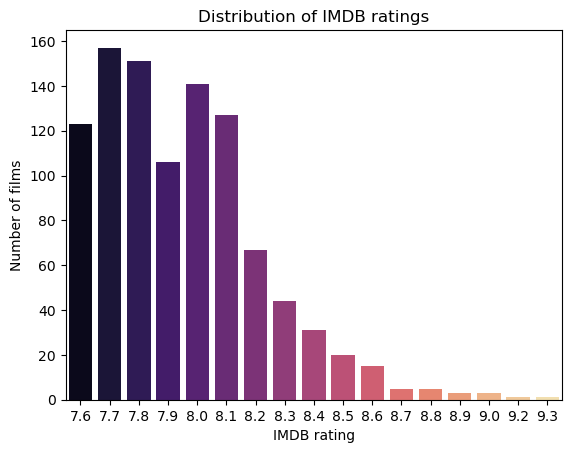

In [171]:
sns.countplot(x='IMDB_Rating', data = imdb_top_1000, palette="magma").set(title='Distribution of IMDB ratings',xlabel='IMDB rating', ylabel='Number of films');


In [173]:
C = imdb_top_1000['IMDB_Rating'].mean()
m = imdb_top_1000['No_of_Votes'].min()
v = imdb_top_1000['No_of_Votes']
R = imdb_top_1000['IMDB_Rating']

In [174]:
imdb_top_1000['WR'] = (v / (v + m)) * R + (m / (v + m)) * C # Complete original dataset


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [175]:
imdb_top_1000[['Series_Title','IMDB_Rating','WR','No_of_Votes']].sort_values('WR', ascending=False).head()

,Series_Title,IMDB_Rating,WR,No_of_Votes
0,The Shawshank Redemption,9.3,9.285691,2343110
1,The Godfather,9.2,9.180931,1620367
2,The Dark Knight,9.0,8.988679,2303232
3,The Godfather: Part II,9.0,8.977178,1129952
4,12 Angry Men,9.0,8.963129,689845


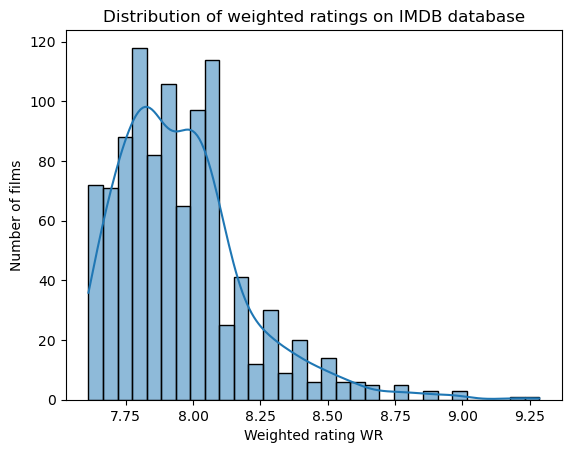

In [176]:
sns.histplot(x='WR', data = imdb_top_1000, kde=True).set(title='Distribution of weighted ratings on IMDB database',xlabel='Weighted rating WR', ylabel='Number of films');


### Merge IMDB database with movie database to have common features

We would like to merge the data from CMU movies and IMDB top 1000. Since we don't want to reduce the size of data, we would rather to an outer merge and fill missing values with NaN.

In [177]:
len((imdb_top_1000['Series_Title'] + imdb_top_1000['Released_Year'].astype(str)).unique()) / len(imdb_top_1000)

1.0

In [178]:
# Remove duplicated movie with video game
movies.drop(movies[movies['wikipedia_id'] == 3184269].index, inplace=True)
# Fix duplicated movie with changing it release year to the correct one based on its wikipedia page
movies.loc[movies['wikipedia_id'] == 25357930, ['release_year']] = "2010"

In [179]:
imdb_top_1000.rename({'Series_Title': 'name', 'Released_Year': 'release_year'}, axis=1, inplace=True)

In [180]:
imdb_top_1000.loc[imdb_top_1000['name'] == 'Apollo 13', 'release_year'] = '1995' # The release year was wrong in the dataset change from PG to 1995 /year was obtained from wikipedia/
movies['release_year'] = movies['release_year'].replace('nan', np.nan).astype('float').astype('Int16')
movies['release_month'] = movies['release_month'].replace('nan', np.nan).astype('float').astype('Int16')
movies['release_day'] = movies['release_day'].replace('nan', np.nan).astype('float').astype('Int16')
imdb_top_1000['release_year'] = imdb_top_1000['release_year'].replace('nan', np.nan).astype('float').astype('Int16')


In [181]:
movie_feature = imdb_top_1000.merge(movies, on=['name', 'release_year'], how='outer')


In [182]:
def fill_NaN(df, column_left, column_right, column_name=None): # Updates missing data from left column with right column data
    if column_name is None:
        column_name = column_left
    df[column_name] = df[column_left].fillna(df[column_right])

In [183]:
movie_feature['Genre'] = movie_feature['Genre'].replace(np.nan, '').apply(lambda x: x.split(', '))

fill_NaN(movie_feature,'runtime','Runtime')
fill_NaN(movie_feature,'genres','Genre')
movie_feature.drop(labels=['Runtime','Genre'], axis=1, inplace=True)

In [184]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

In [185]:
movie_feature.sample(3)

,Poster_Link,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,...,WR,wikipedia_id,freebase_id,box_office_revenue,runtime,languages,countries,genres,release_month,release_day
56809,NaN,Saravarsham,1982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,36114256.0,/m/0k0t_kq,NaN,NaN,[Malayalam],[India],"[Crime Fiction, Thriller, Drama]",<NA>,<NA>
51888,NaN,Lords of the Deep,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6575394.0,/m/0gc7vx,NaN,95.0,[English],[United States of America],"[Thriller, Science Fiction, Horror]",4,21
4495,NaN,Sue,1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,32326508.0,/m/0gtl4b4,NaN,90.0,NaN,[United States of America],[Drama],<NA>,<NA>


In [186]:
movie_feature.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,Gross,WR,wikipedia_id,box_office_revenue,runtime,release_month,release_day
count,75235.000000,1000.000000,843.000000,1.000000e+03,8.310000e+02,1000.000000,8.174000e+04,8.401000e+03,61695.000000,42666.000000,39372.000000
mean,1977.602419,7.949300,77.971530,2.736929e+05,6.803475e+07,7.957808,1.740801e+07,4.799363e+07,93.842314,6.692495,15.651656
std,29.115190,0.275491,12.376099,3.273727e+05,1.097500e+08,0.242824,1.098786e+07,1.121753e+08,51.436090,3.483249,8.715623
min,1010.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,7.611562,3.300000e+02,1.000000e+04,0.000000,1.000000,1.000000
25%,1956.000000,7.700000,70.000000,5.552625e+04,3.253559e+06,7.799293,7.323722e+06,2.083193e+06,81.000000,4.000000,8.000000
50%,1985.000000,7.900000,79.000000,1.385485e+05,2.353089e+07,7.913042,1.777899e+07,1.063969e+07,93.000000,7.000000,16.000000
75%,2004.000000,8.100000,87.000000,3.741612e+05,8.075089e+07,8.077983,2.715589e+07,4.071696e+07,107.000000,10.000000,23.000000
max,2020.000000,9.300000,100.000000,2.343110e+06,9.366622e+08,9.285691,3.750192e+07,2.782275e+09,5100.000000,12.000000,31.000000


In [187]:
print(f'There are {(imdb_top_1000.shape[0]+movies.shape[0]) - movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb_top_1000.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


There are 603 common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes 1000 elements and Movie corpus includes 81740.


In [188]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

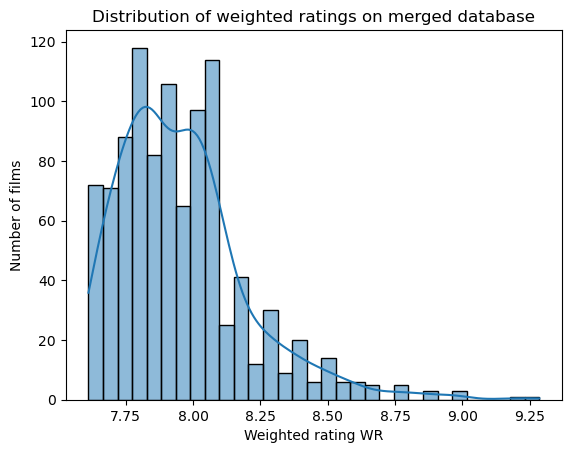

In [189]:
sns.histplot(x='WR', data=movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


In [190]:
len((movie_feature['name'] + movie_feature['release_year'].astype(str)).unique()) / len(movie_feature)

0.9977476654857129

### Fill missing budget data from imdb budget dataset

In [191]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1759,Changeling,2008,7.7,R,141,"Biography, Crime, Drama","Oct 24, 2008",55000000,35739802,113805580
3580,Four Lions,2010,7.3,R,97,"Comedy, Crime, Drama","Nov 5, 2010",3750000,310007,8607693
2102,Ricki and the Flash,2015,5.9,PG-13,101,"Comedy, Drama, Music","Aug 7, 2015",18000000,26839498,41166033
3176,Kundun,1997,7.0,PG-13,134,"Biography, Drama, History","Dec 25, 1997",28000000,5686694,5686694
1161,Boyz n the Hood,1991,7.7,R,112,"Crime, Drama","Jul 12, 1991",6500000,56190094,56215095


In [192]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date

In [193]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('Int16')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('Int16')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('Int16')

In [194]:
imdb_budget.drop(['Year', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [195]:
imdb_budget.describe()

,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08,2003.594044,7.322100,15.891066
std,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08,12.767740,3.378479,8.437532
min,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [196]:
len((movie_feature['name'] + str(movie_feature['release_year'])).unique()) / len(movie_feature)

0.9232380047968638

In [197]:
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [198]:
movie_feature.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres',
       'release_month', 'release_day'],
      dtype='object')

In [199]:
movie_feature_with_budget = movie_feature.merge(imdb_budget, on=['name', 'release_year'], how='outer')

In [200]:
movie_feature_with_budget.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'release_month_x', 'release_day_x', 'IMDb', 'Rating', 'Runtime',
       'genres_y', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y'],
      dtype='object')

In [201]:
fill_NaN(movie_feature_with_budget,'genres_x','genres_y','genre')
fill_NaN(movie_feature_with_budget,'release_day_x','release_day_y','release_day')
fill_NaN(movie_feature_with_budget,'release_month_x','release_month_y','release_month')
fill_NaN(movie_feature_with_budget,'Certificate','Rating')
fill_NaN(movie_feature_with_budget,'runtime','Runtime')
fill_NaN(movie_feature_with_budget,'IMDB_Rating','IMDb')

### Investigate the gross difference between the original and the imdb budget datasets

<AxesSubplot:title={'center':'Distribution of the difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

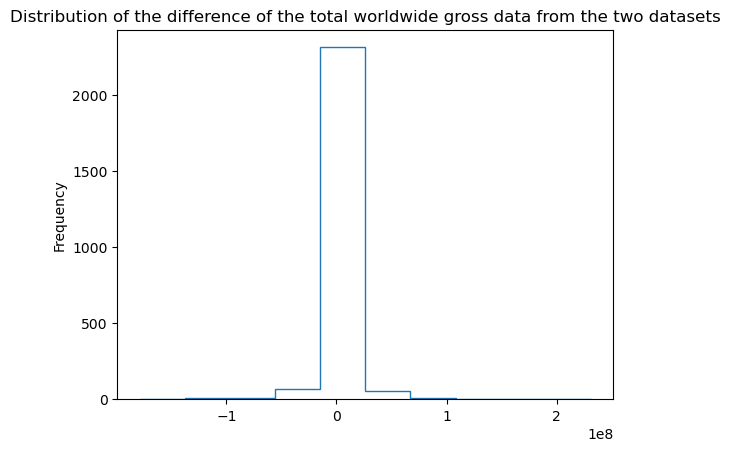

In [202]:
(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the total worldwide gross data from the two datasets')

<AxesSubplot:title={'center':'Distribution of the percentage in difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

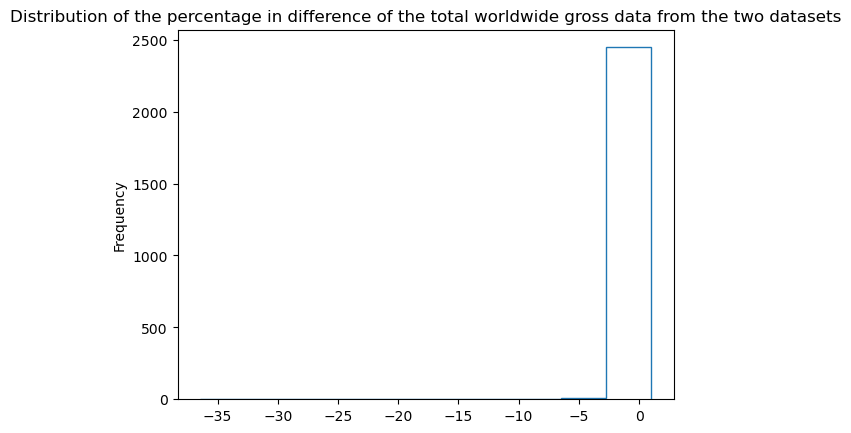

In [203]:
((movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']).plot(kind='hist', histtype='step', title='Distribution of the percentage in difference of the total worldwide gross data from the two datasets')

In [204]:
movie_feature_with_budget_differences = movie_feature_with_budget.copy()
movie_feature_with_budget_differences['gross_difference'] = np.abs(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'])
movie_feature_with_budget_differences['gross_difference%'] = ((np.abs(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']) * 100).round(2)

In [205]:
# Difference between the total worldwide gross data from the two datasets
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference'] != 0) & (~movie_feature_with_budget_differences['gross_difference'].isna())] \
    .sort_values('gross_difference%', ascending=False) \
    [['name', 'box_office_revenue', 'Worldwide Gross', 'gross_difference', 'gross_difference%']]

,name,box_office_revenue,Worldwide Gross,gross_difference,gross_difference%
2614,The Son of No One,30680.0,1148578.0,1117898.0,3643.74
11355,Restless,163265.0,2772511.0,2609246.0,1598.17
4303,Welcome to Collinwood,336620.0,4606284.0,4269664.0,1268.39
31033,Margaret,46495.0,623292.0,576797.0,1240.56
458,The Wizard of Oz,3017000.0,34949482.0,31932482.0,1058.42
...,...,...,...,...,...
16293,Mrs. Doubtfire,441286195.0,441286003.0,192.0,0.00
795,Ocean's Eleven,450717150.0,450728529.0,11379.0,0.00
78873,The Dead Zone,20766616.0,20766000.0,616.0,0.00
5526,Failure to Launch,128406887.0,128402901.0,3986.0,0.00


In [206]:
# Percentage differences between the gross data from the two datasets
movie_feature_with_budget_differences.describe(percentiles=[.25, .5, .75, .8, .9, .95])[['gross_difference%']]

,gross_difference%
count,2468.000000
mean,16.436353
std,101.362374
min,0.000000
25%,0.020000
50%,0.695000
75%,5.455000
80%,9.888000
90%,34.123000
95%,62.818000


In [207]:
movie_feature_with_budget_differences[movie_feature_with_budget_differences['gross_difference'] == 0].shape[0] / movie_feature_with_budget_differences['gross_difference%'].notna().sum()

0.15842787682333873

In [208]:
movie_feature_with_budget_differences[
    (movie_feature_with_budget_differences['name'] == 'The Son of No One') |
    (movie_feature_with_budget_differences['name'] == 'Restless') |
    (movie_feature_with_budget_differences['name'] == 'Welcome to Collinwood')
][[
    'name', 'box_office_revenue', 'Worldwide Gross'
]]

,name,box_office_revenue,Worldwide Gross
2614,The Son of No One,30680.0,1148578.0
4303,Welcome to Collinwood,336620.0,4606284.0
11355,Restless,163265.0,2772511.0
19658,Restless,NaN,NaN
32477,Restless,NaN,NaN


In [209]:
# gross_difference = box_office_revenue - Worldwide Gross
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] > 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] < 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] == 0).sum())
(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross']).describe()

1012
1065
391


count    2.468000e+03
mean     4.134445e+05
std      1.569719e+07
min     -1.785914e+08
25%     -6.153875e+05
50%      0.000000e+00
75%      1.989842e+05
max      2.310745e+08
dtype: float64

We want to fill the missing data from the imdb budget dataset. For this purpose we are comparing the difference between the CMU, imdb top 1000, and imdb budget data. We have the:
 
 * `box_office_revenue` - from CMU with 8401 values /total gross/
 * `Gross` - from imdb top 1000 with 831 values /total gross in US and Canada/
 * `Domestic Gross` - from imdb budget with 3841 values /total gross in US and Canada/
 * `Worldwide Gross` - from imdb budget with 3841 values /total gross/

We would only consider the total worldwide gross since we are investigating movies from the whole world. The information for it is contained in the `box_office_revenue` and `Worldwide Gross`. Only around 20% of the values for the total gross are the same. Also, we know that the other data in `box_office_revenue` is not bigger or smaller than the `Worldwide Gross` for all records. So we can conclude that `box_office_revenue` and `Worldwide Gross` are not connected.

Based on this, we cannot combine the data from the both datasets and we would prefer using the data from the imdb budget dataset because it contains information about the budget of the movie and the data inside seams more accurate based on the comparison of a subset of it with Wikipedia data.

In [210]:
movie_feature_with_budget.columns

Index(['Poster_Link', 'name', 'release_year', 'Certificate', 'IMDB_Rating',
       'Overview', 'Meta_score', 'Director', 'Star1', 'Star2', 'Star3',
       'Star4', 'No_of_Votes', 'Gross', 'WR', 'wikipedia_id', 'freebase_id',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres_x',
       'release_month_x', 'release_day_x', 'IMDb', 'Rating', 'Runtime',
       'genres_y', 'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'genre', 'release_day',
       'release_month'],
      dtype='object')

In [211]:
# Remove merged extra columns 
movie_feature_with_budget.drop(['box_office_revenue','Domestic Gross','Gross','Rating',
                                'Runtime','IMDb','release_month_x','release_month_y','release_day_x',
                                'release_day_y','genres_x','genres_y'], axis=1, inplace=True)

# Rename gross column
movie_feature_with_budget.rename({'Worldwide Gross': 'total_gross'}, axis=1, inplace=True)

# Remove data that won't be used in the analysis
movie_feature_with_budget.drop(['Poster_Link'], axis=1, inplace=True) 

# Compute profit as success indicator
movie_feature_with_budget['profit'] = movie_feature_with_budget['total_gross'] - movie_feature_with_budget['Production Budget']

In [212]:
movie_feature_with_budget.columns

Index(['name', 'release_year', 'Certificate', 'IMDB_Rating', 'Overview',
       'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4',
       'No_of_Votes', 'WR', 'wikipedia_id', 'freebase_id', 'runtime',
       'languages', 'countries', 'Production Budget', 'total_gross', 'genre',
       'release_day', 'release_month', 'profit'],
      dtype='object')

In [213]:
movie_feature_with_budget.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,WR,wikipedia_id,runtime,Production Budget,total_gross,release_day,release_month,profit
count,76183.000000,4399.000000,843.000000,1.000000e+03,1000.000000,8.174000e+04,62713.000000,3.841000e+03,3.841000e+03,40599.000000,43858.000000,3.841000e+03
mean,1978.059410,6.648011,77.971530,2.736929e+05,7.957808,1.740801e+07,94.079673,4.028301e+07,1.205057e+08,15.658834,6.707875,8.022274e+07
std,29.227715,1.058971,12.376099,3.273727e+05,0.242824,1.098786e+07,51.095357,4.475082e+07,1.991119e+08,8.708488,3.483286,1.694921e+08
min,1010.000000,1.500000,28.000000,2.508800e+04,7.611562,3.300000e+02,0.000000,7.000000e+03,0.000000e+00,1.000000,1.000000,-1.580898e+08
25%,1956.000000,6.000000,70.000000,5.552625e+04,7.799293,7.323722e+06,82.000000,1.100000e+07,1.686693e+07,8.000000,4.000000,-3.452140e+05
50%,1986.000000,6.700000,79.000000,1.385485e+05,7.913042,1.777899e+07,93.000000,2.500000e+07,5.071937e+07,16.000000,7.000000,2.289719e+07
75%,2004.000000,7.500000,87.000000,3.741612e+05,8.077983,2.715589e+07,107.000000,5.000000e+07,1.379848e+08,23.000000,10.000000,8.861348e+07
max,2020.000000,9.300000,100.000000,2.343110e+06,9.285691,3.750192e+07,5100.000000,4.000000e+08,2.797801e+09,31.000000,12.000000,2.551701e+09


In [214]:
movie_feature_with_budget.sample(5)

,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,freebase_id,runtime,languages,countries,Production Budget,total_gross,genre,release_day,release_month,profit
73871,Gizmo!,1977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/08vdy7,NaN,NaN,[United States of America],NaN,NaN,"[Comedy, Documentary]",<NA>,<NA>,NaN
12491,Martial Club,1981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/02qkz50,102.0,[Cantonese],[Hong Kong],NaN,NaN,"[Action/Adventure, Action, Martial Arts Film, ...",<NA>,<NA>,NaN
55305,Analog Days,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/0kv8d9,90.0,[English],[United States of America],NaN,NaN,"[Ensemble Film, Drama, Indie]",24,6,NaN
7797,48 Hours of Hallucinatory Sex,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/047r6bt,99.0,[Portuguese],[Brazil],NaN,NaN,"[Adult, Pornographic movie]",27,4,NaN
9300,That Gang of Mine,1940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,/m/0598jf,62.0,[English],[United States of America],NaN,NaN,"[Comedy, Black-and-white]",23,9,NaN


## Account for inflation: 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate.

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [215]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [216]:
df = movie_feature_with_budget.copy()

In [217]:
# Initialisation
df['profit_modified'] = df['profit']
df['total_gross_modified'] = df['total_gross']

In [218]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'total_gross_modified'] = decade_df['total_gross'] * inflation_rate   

In [219]:
movie_feature_with_budget = df.copy()

In [220]:
movie_feature_with_budget.head(2)

,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,languages,countries,Production Budget,total_gross,genre,release_day,release_month,profit,profit_modified,total_gross_modified
0,The Shawshank Redemption,1994,A,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,...,[English],[United States of America],25000000.0,28417060.0,"[Crime Fiction, Buddy film, Prison film, Drama...",10,9,3417060.0,4.560750e+06,3.792825e+07
1,The Godfather,1972,A,9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,...,"[Latin, Italian, Sicilian, English]",[United States of America],7000000.0,268500000.0,"[Crime Fiction, Gangster Film, Crime Drama, Fa...",15,3,261500000.0,3.353214e+08,3.442976e+08


In [222]:
# Delete the columns for budget which are not modified by inflation rate: 
movie_feature_with_budget.drop(['total_gross','profit'], axis=1, inplace=True)

### Wikipedia pageviews

In [223]:
wikipedia_pageviews['date'] = pd.to_datetime(wikipedia_pageviews['date'], format='%Y%m%d%H')

In [224]:
wikipedia_pageviews.sample(5)

,movie_name,date,pageviews
226734,Shrek,2017-06-17,2503
370232,Ted,2020-10-06,72
1101420,The Curious Case of Benjamin Button,2021-04-07,90
230128,Despicable Me 3,2019-05-17,1218
368036,Mrs. Doubtfire,2022-02-17,1258


In [225]:
wikipedia_pageviews.describe()

,pageviews
count,2.301748e+06
mean,1.688527e+03
std,6.576590e+03
min,0.000000e+00
25%,1.170000e+02
50%,8.810000e+02
75%,1.891000e+03
max,1.982874e+06


In [226]:
wikipedia_pageviews.rename({'movie_name': 'name'}, axis=1, inplace=True)

In [227]:
wikipedia_pageviews_mean_per_day = wikipedia_pageviews.groupby('name').mean()
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews_mean_per_day, on='name', how='left')

In [228]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,release_year,IMDB_Rating,Meta_score,No_of_Votes,WR,wikipedia_id,runtime,Production Budget,release_day,release_month,profit_modified,total_gross_modified,pageviews
count,76183.000000,4399.000000,843.000000,1.000000e+03,1000.000000,8.174000e+04,62713.000000,3.841000e+03,40599.000000,43858.000000,3.841000e+03,3.841000e+03,1198.000000
mean,1978.059410,6.648011,77.971530,2.736929e+05,7.957808,1.740801e+07,94.079673,4.028301e+07,15.658834,6.707875,1.020213e+08,1.529179e+08,1629.608527
std,29.227715,1.058971,12.376099,3.273727e+05,0.242824,1.098786e+07,51.095357,4.475082e+07,8.708488,3.483286,2.116340e+08,2.471666e+08,2306.323344
min,1010.000000,1.500000,28.000000,2.508800e+04,7.611562,3.300000e+02,0.000000,7.000000e+03,1.000000,1.000000,-1.887276e+08,0.000000e+00,0.833333
25%,1956.000000,6.000000,70.000000,5.552625e+04,7.799293,7.323722e+06,82.000000,1.100000e+07,8.000000,4.000000,-4.548600e+05,2.182930e+07,96.998887
50%,1986.000000,6.700000,79.000000,1.385485e+05,7.913042,1.777899e+07,93.000000,2.500000e+07,16.000000,7.000000,3.032431e+07,6.537242e+07,963.526160
75%,2004.000000,7.500000,87.000000,3.741612e+05,8.077983,2.715589e+07,107.000000,5.000000e+07,23.000000,10.000000,1.134429e+08,1.742373e+08,2170.703618
max,2020.000000,9.300000,100.000000,2.343110e+06,9.285691,3.750192e+07,5100.000000,4.000000e+08,31.000000,12.000000,3.274088e+09,3.578183e+09,37415.568125


In [229]:
# For simplicity of use, we rename the dataframe
df_all = movie_feature_with_budget_and_wikipedia_pageviews

For the final dataset obtained, we gather data from 4 different sources. In order to not restrain ourselves to only common features and end up with a smaller dataset, we made the choice of outer merges filled with NaN. Indeed, if we had taken inner merge of all datasets, it might be that our final dataset is both small and not badly representative of the population. 

Having NaN values has however some consequences on our data analysis. It might be that the NaN are not fully random, for instance, runtime for Crime movies are all missing values while we have the runtime for all Comedies. This should ideally be investigated further to check the NaN are indeed random. In the framework of this milestone, the choice was to focus on other tasks. We will thus assume randomness of NaN values.



# Exploratory Data Analysis

## Success indicators

Success of a movie can be very subjective. We thus need to diversify our definitions of success to have a holistic view of our dataset. The following success indicators are considered: 
- How well a movie is received: 
    IMDB ratings which should be weighted by the number of votes
- How profitable a movie is: 
    Overall gross revenue of the movie OR profit = gross revenue - budget spent
- How long a movie will last in time: 
    Number of connection to the movie wikipedia page


## Explore data

Looking at the impacts of features on eachother by drawing a correlation heatmap

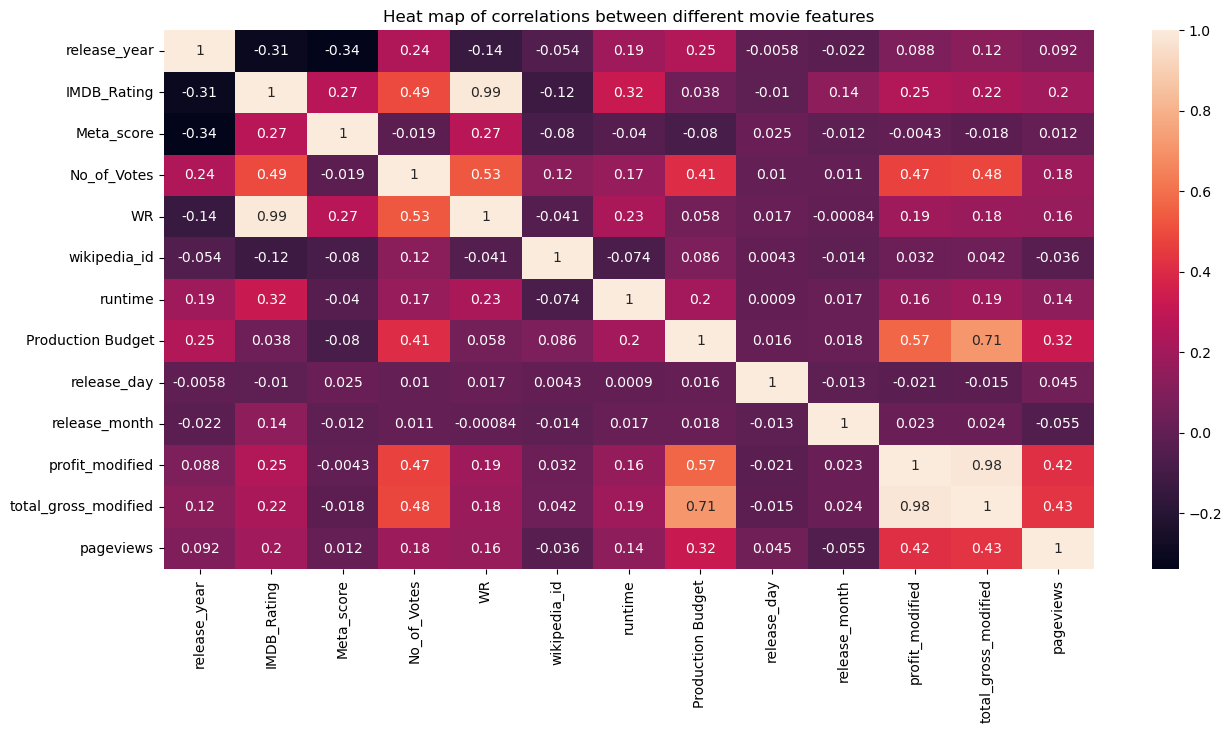

In [230]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


### ADD comment on correlation results !!!

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the 'box_office_revenue'. Since 'WR' and 'release_month' are features coming from two different datasets, we need to use the merged dataframe movie_feature which contains only 875. We can then compare the results found with ('WR','release_month') to ('box_office_revenue','release_month') which is based on much more data: 81741. 

-> CAREFUL, WHY ARE RATINGS AND GROSS REVENUE COMPLETELY UNCORRELATED ? 

In [231]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the release month information for {df_all['release_month'].count()} movies which is a big enough dataset to be representative.")

Out of 83085 movies in out dataset, we have the release month information for 43858 movies which is a big enough dataset to be representative.


In [232]:
df_release = df_all.dropna(how='all', subset=['release_month']) # Remove NaN months

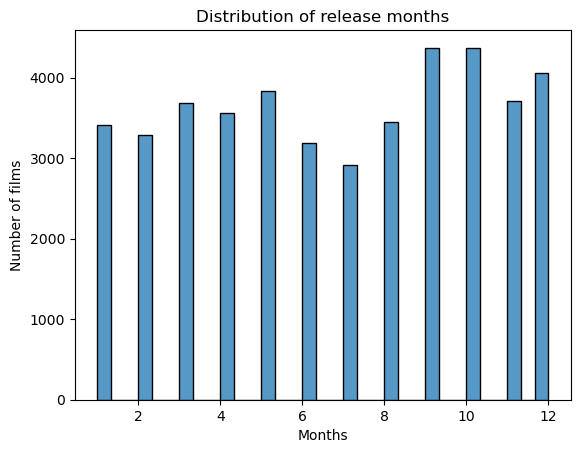

In [233]:
sns.histplot(x='release_month', data = df_release).set(title='Distribution of release months',xlabel='Months', ylabel='Number of films');

From the plot above, we can see that the distribution of release months is fairly homogeneous accross the data which allows to investigate success accross different release months.

In [234]:
df_release=df_release.sort_values(by='release_month', ascending=True)

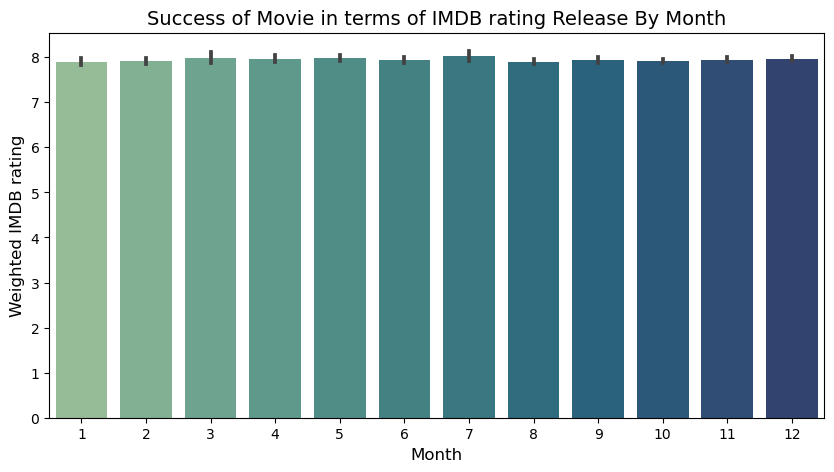

In [235]:
# Plot
plt.figure(figsize=(10,5));
ax = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest');
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Success of Movie in terms of IMDB rating Release By Month', fontsize=14);

Text(0.5, 1.0, 'Success in terms of revenue of Movie Release By Month')

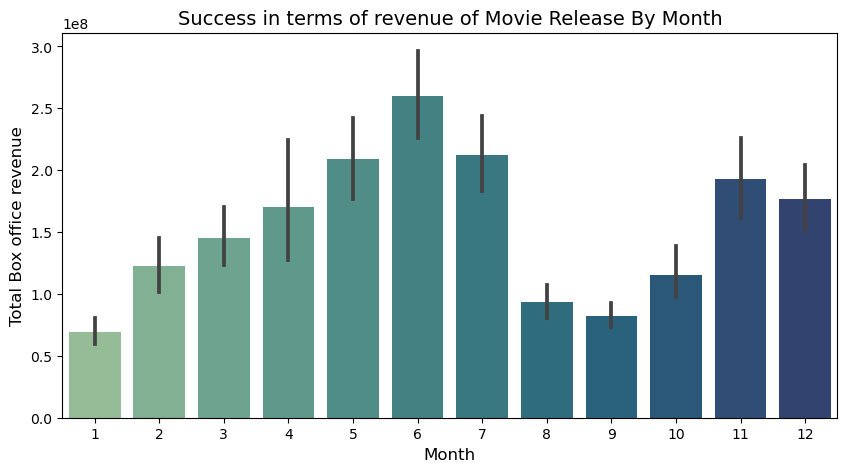

In [238]:
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x="release_month", y="total_gross_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Box office revenue', fontsize=12)
plt.title('Success in terms of revenue of Movie Release By Month', fontsize=14)

UPDATE:


As we can see from the results above, the movie weighted ratings are not at all influenced by the release period. However, the gross revenue is. In particular, if we look at the release gross revenue in the 5 days following release, we see that movies released in summer and in the end of the year are more successful. This follows the same trend as the total gross revenue meaning that this difference in success across months is probably due to the cinema revenue in the first 5 days. Since the distribution of movies is fairly the same across our dataset, we can deduce that these periods are more favourable for movie release. This result coincides with usual holidays periods where people have more time to go to the cinema. 

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare mainly three features, the budget spent 'Production Budget', the profit made 'profit' and the weighted rating of the movie to account for successfulness 'WR'.


In [239]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the profit information for {df_all['profit_modified'].count()} movies, total gross revenue information for {df_all['total_gross_modified'].count()} movies , budget information for {df_all['Production Budget'].count()} movies.")

Out of 83085 movies in out dataset, we have the profit information for 3841 movies, total gross revenue information for 3841 movies , budget information for 3841 movies.


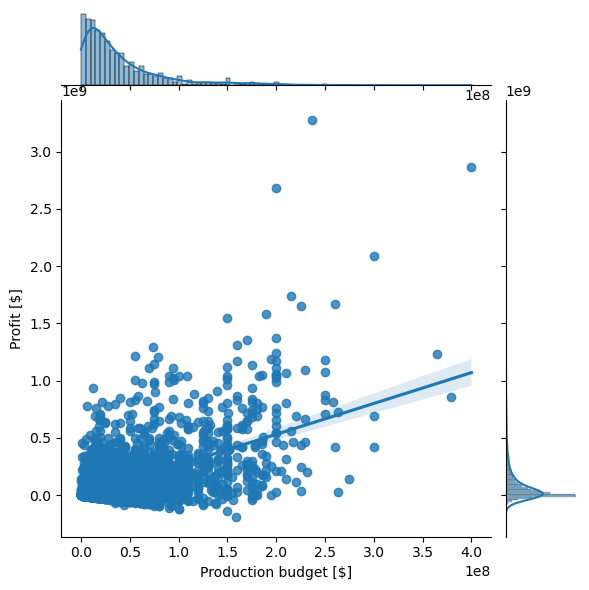

In [240]:
h = sns.jointplot(data=df_all, x='Production Budget', y='profit_modified', kind="reg");
h.ax_joint.set_xlabel('Production budget [$]');
h.ax_joint.set_ylabel('Profit [$]');

As we can see from the plot above, the positive trend line indicates that an increase in the budget will result in an increase in profit. However, there seems to be a lot of outliers. For our datastory (Milestone 3), it would be interesting to split this into two categories, high budget movies and average movies. Additionnaly, we will want to investigate if this budget trend is different across genres.

To compare the link between all three features, we build the pairplot below:

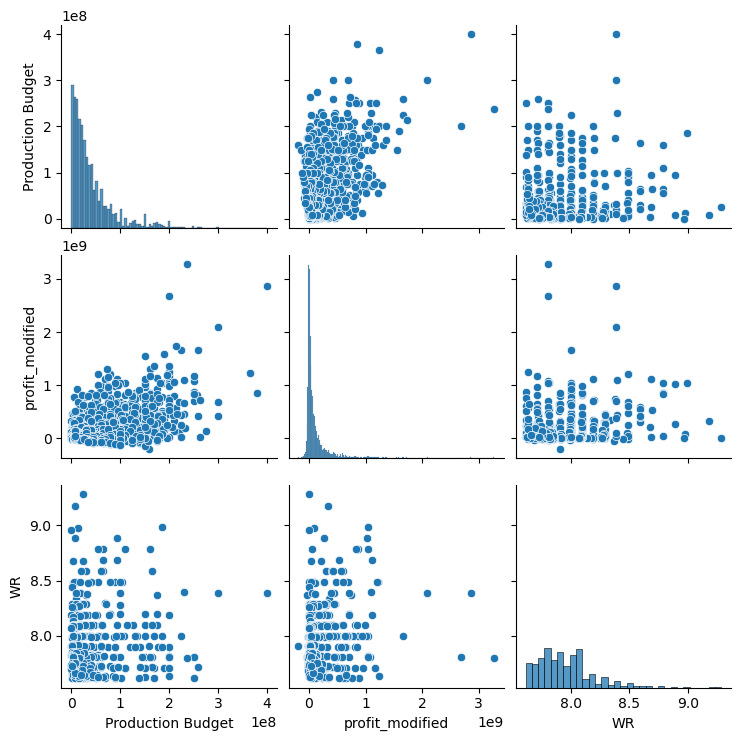

In [241]:
sns.pairplot(movie_feature_with_budget[['Production Budget','profit_modified','WR']]);

### Top 20 most profitable movies

In [242]:
Top20_ProfitableMovies = df_all.sort_values('profit_modified', ascending=False).head(20)

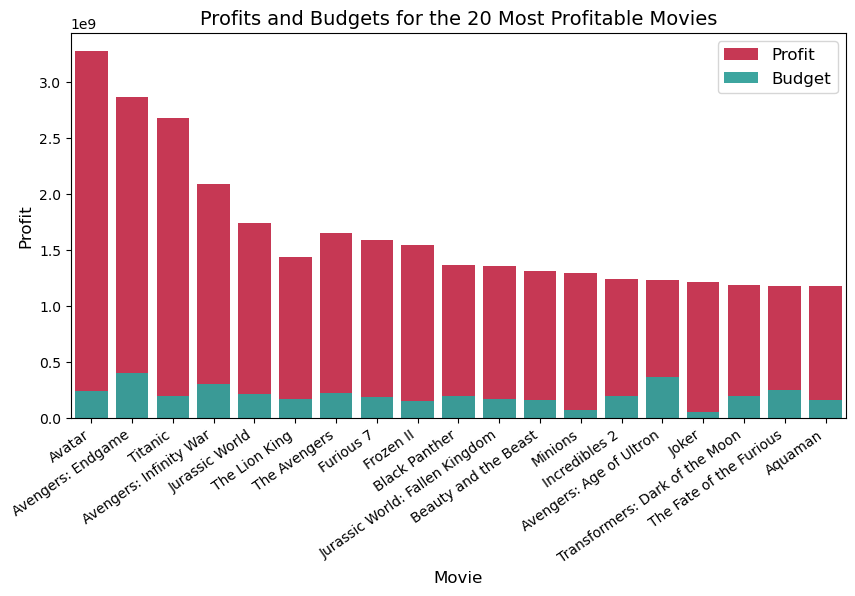

In [243]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

### Top lasting movies

### ---->TO COMPLETE MY MEHDI  with wikipedia connection

## Impact of director

In [244]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the director information for {df_all['Director'].count()} movies coming from the top 1000 IMDB data set.")

Out of 83085 movies in out dataset, we have the director information for 1000 movies coming from the top 1000 IMDB data set.


In [245]:
df_director = df_all.dropna(how='all', subset=['Director']) # Remove NaN directors

In [246]:
Top20_ProfitableMovies = df_director.sort_values('profit_modified', ascending=False).head(20)

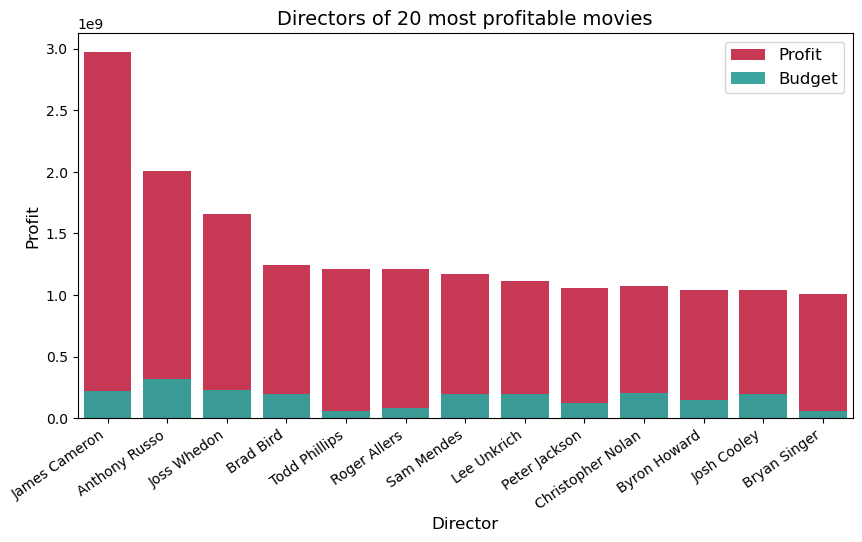

In [247]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [248]:
Top20_ProfitableMovies['Director']

623        James Cameron
59         Anthony Russo
652        James Cameron
60         Anthony Russo
357          Joss Whedon
891            Brad Bird
33         Todd Phillips
43          Roger Allers
751           Sam Mendes
151          Lee Unkrich
13         Peter Jackson
63     Christopher Nolan
583        Anthony Russo
618        Peter Jackson
2      Christopher Nolan
330         Byron Howard
596          Josh Cooley
10         Peter Jackson
5          Peter Jackson
342         Bryan Singer
Name: Director, dtype: object

## Impact of actors TO COMPLETE BY PAU

In [249]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the 1st actor information for {df_all['Star1'].count()} movies coming from the top 1000 IMDB data set.")

Out of 83085 movies in out dataset, we have the 1st actor information for 1000 movies coming from the top 1000 IMDB data set.


For now, we only consider the main actor of a movie but this can be extrapolated to all actors accross multiple movies for our next milestone. 

In [250]:
df_main_actor = df_all.dropna(how='all', subset=['Star1']) # Remove NaN actors

In [251]:
Top20_ProfitableMovies = df_main_actor.sort_values('profit_modified', ascending=False).head(20)

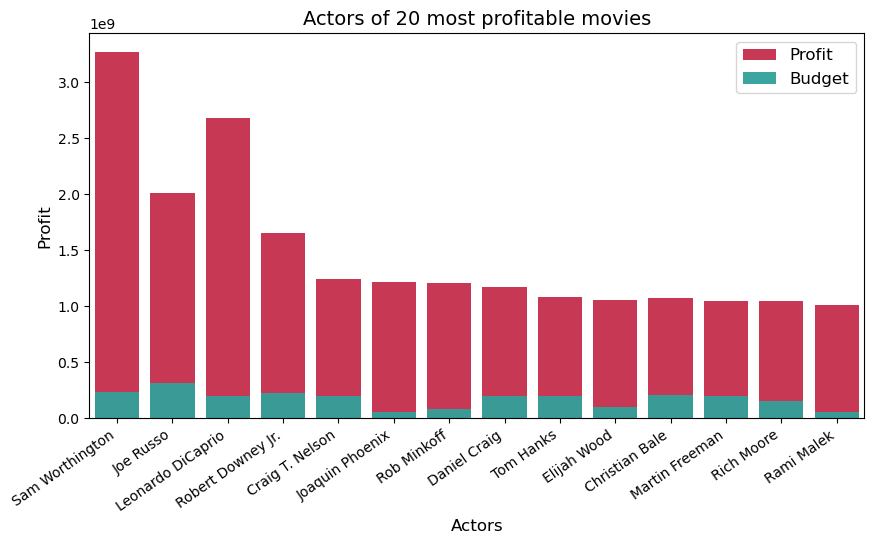

In [252]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['Production Budget'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Actors', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

For our datastory, the goal would be to cluster actors accross genres. That way, we can forecast which actor would be best to select for a particular genre to boost success.

## Popular features in characters

Characters dataset splitted in males and females to easily compare among genders

In [253]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

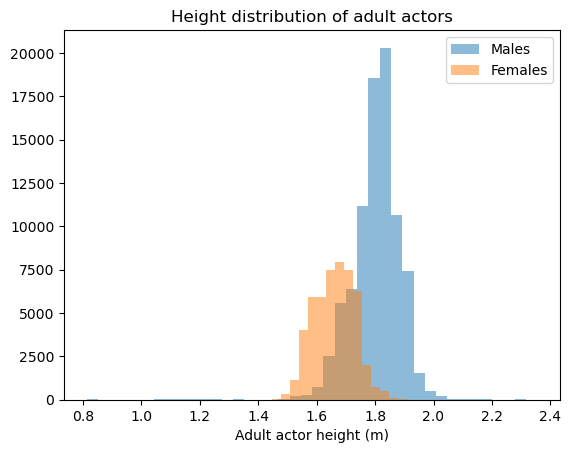

In [254]:
def characters_height_histogram(characters, bins):
    LIMIT_CHILDREN_AGE = 14
    characters_height = characters.dropna(subset=['actor_height_meters'])
    characters_height = characters_height[(characters_height['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(characters_male, bins=40)
characters_height_histogram(characters_female, bins=25)

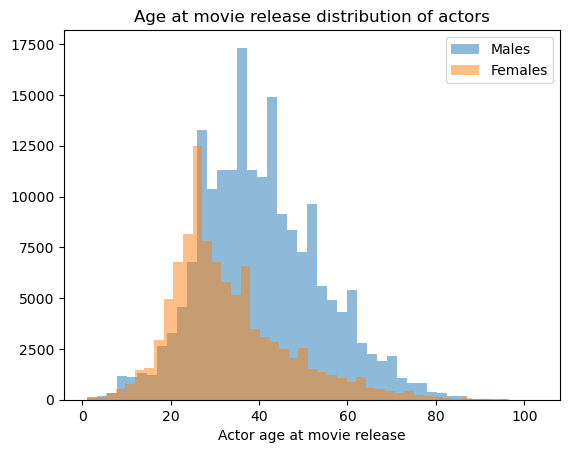

In [255]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

## What genres are the most profitable?

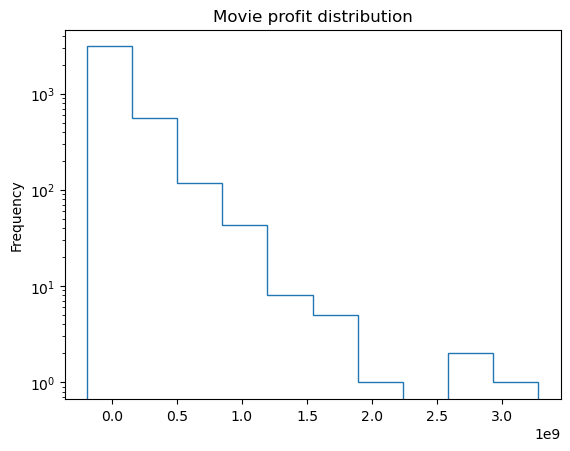

In [256]:
df_all['profit_modified'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution');

In [257]:
df_all['genre1'] = df_all['genre'].apply(lambda el: el[0])

In [276]:
genres = df_all['genre1'].value_counts()

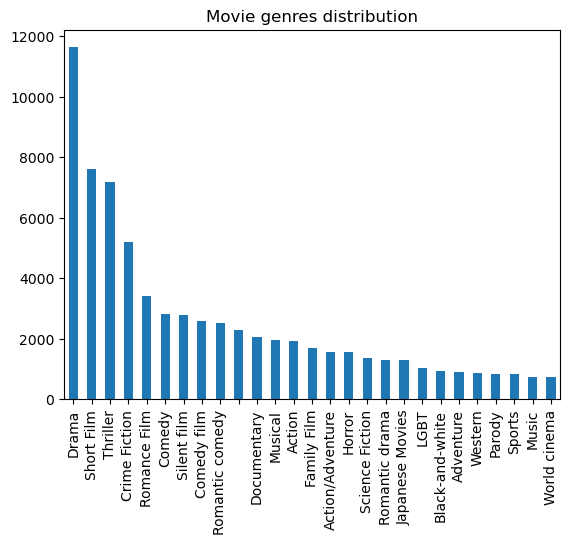

In [306]:
genres[genres > 700].plot(kind='bar', title='Movie genres distribution');

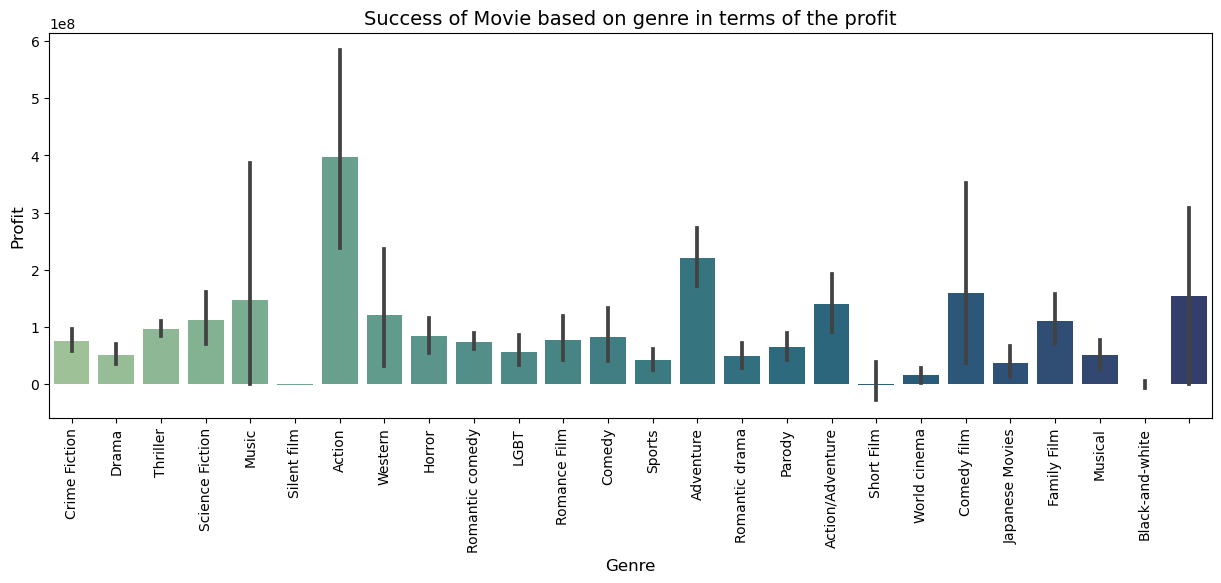

In [309]:
plt.figure(figsize=(15,5));
ax = sns.barplot(
    x="genre1",
    y="profit_modified",
    data=df_all[df_all['profit_modified'].notna() & df_all['genre1'].isin(genres[genres > 700].index.to_list())],
    palette='crest'
)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Success of Movie based on genre in terms of the profit', fontsize=14)
_ = plt.xticks(rotation=90)

## correlation between the choice of topics and movie profitability can be investigated

In [310]:
df_all['genre1_category'] = df_all['genre1'].astype('category').cat.codes

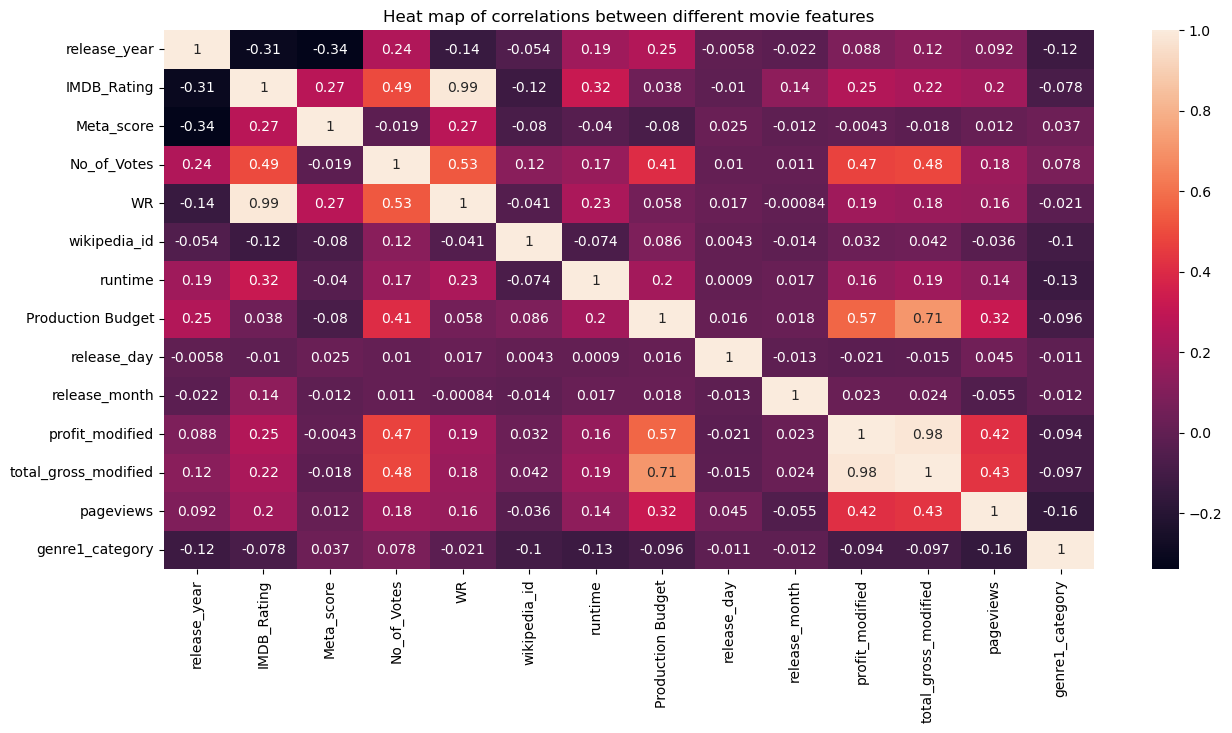

In [311]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [312]:
wikipedia_pageviews.sample(5)

,name,date,pageviews
1956870,Airplane!,2018-12-15,1202
2247997,Zombieland,2019-02-24,1777
955505,Bad Boys II,2018-06-19,809
722701,Clash of the Titans,2020-02-27,12
1758360,Elysium,2017-06-03,4022


<AxesSubplot:title={'center':'Pageviews for Spy Kids'}, xlabel='date'>

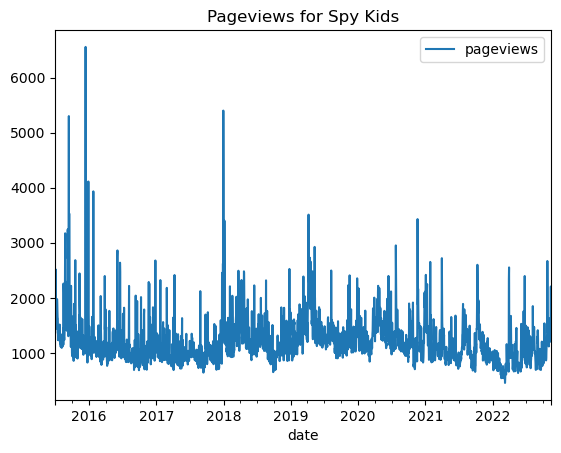

In [313]:
wikipedia_pageviews[wikipedia_pageviews['name'] == 'Spy Kids'].plot(x='date', y='pageviews', title='Pageviews for Spy Kids')

<AxesSubplot:title={'center':'Pageviews for Avengers: Endgame'}, xlabel='date'>

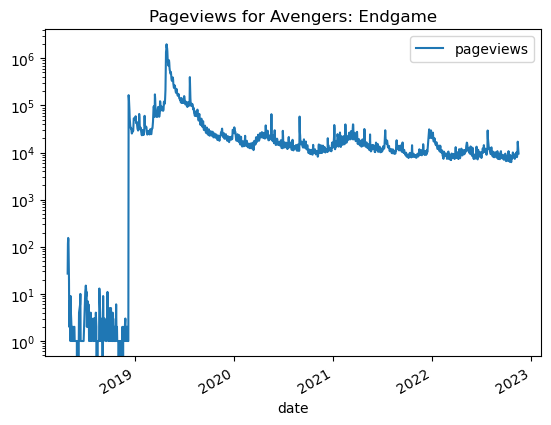

In [314]:
wikipedia_pageviews[wikipedia_pageviews['name'] == 'Avengers: Endgame'].plot(x='date', y='pageviews', logy=True, title='Pageviews for Avengers: Endgame')

In [315]:
df_all.sample(5)

,name,release_year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,...,countries,Production Budget,genre,release_day,release_month,profit_modified,total_gross_modified,pageviews,genre1,genre1_category
27841,Nanban,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[India],NaN,"[Romance Film, Drama, Comedy film]",26,10,NaN,NaN,NaN,Romance Film,240
58526,Orange Blossom for your Wedding,1950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[Mexico],NaN,"[Comedy film, Drama]",<NA>,<NA>,NaN,NaN,NaN,Comedy film,62
20095,Double X: The Name of the Game,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[United Kingdom],NaN,[Thriller],5,6,NaN,NaN,NaN,Thriller,285
55386,Polizón a bordo,1941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[Spain],NaN,[],<NA>,<NA>,NaN,NaN,NaN,,0
31507,Shipwrecked Among Cannibals,1920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,[United States of America],NaN,"[Silent film, Adventure, Documentary]",4,7,NaN,NaN,NaN,Silent film,256


In [316]:
df_all.columns

Index(['name', 'release_year', 'Certificate', 'IMDB_Rating', 'Overview',
       'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4',
       'No_of_Votes', 'WR', 'wikipedia_id', 'freebase_id', 'runtime',
       'languages', 'countries', 'Production Budget', 'genre', 'release_day',
       'release_month', 'profit_modified', 'total_gross_modified', 'pageviews',
       'genre1', 'genre1_category'],
      dtype='object')

In [319]:
df_all['release_year'] = df_all['release_year'].astype(np.int64)

ValueError: cannot convert to 'int64'-dtype NumPy array with missing values. Specify an appropriate 'na_value' for this dtype.

In [318]:
mod = smf.ols(formula='pageviews ~ release_year + runtime + WR + Director + Star1 + Star2 + Star3 + Star4 + Gross + profit + genre1', data=df_all[df_all['release_year'] < (2015-15)])
np.random.seed(2)
res = mod.fit()
res.summary()

TypeError: Cannot interpret 'Int16Dtype()' as a data type